# Try to add a nifty model for sampling the input map

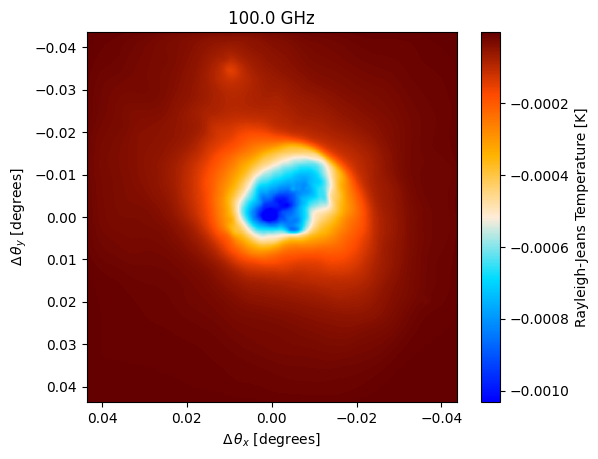

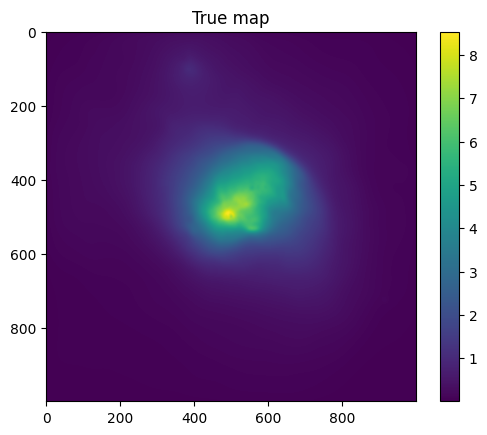

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()
plt.show()

# Sava mapdata as jax array
mapdata_input = np.float64((input_map.data[0].T)*-1e7)

plt.imshow(mapdata_input)
plt.colorbar()
plt.title('True map')
plt.show()

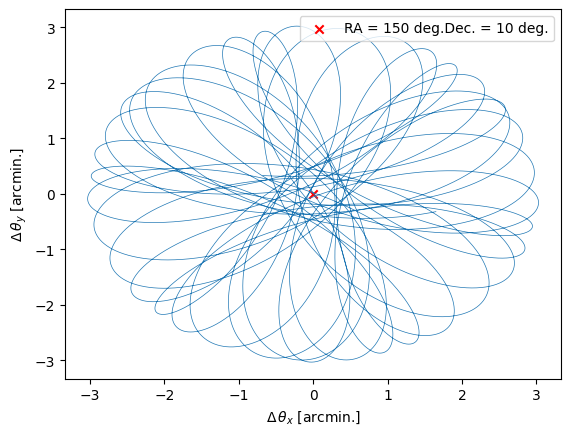

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       noise=False,
                      #  atmosphere="2d",
                    #    cmb="generate",
                      )

tod_truthmap = sim_truthmap.run()

2024-07-25 15:58:49.326 INFO: Constructed instrument.
2024-07-25 15:58:49.327 INFO: Constructed plan.
2024-07-25 15:58:49.328 INFO: Constructed site.
2024-07-25 15:58:49.886 INFO: Constructed boresight.
2024-07-25 15:58:50.149 INFO: Constructed offsets.


Initialized base in 823 ms.


Sampling map (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

INPUTS map_power:
dx[band_mask] [[-1.9628652e-04 -1.9276464e-04 -1.8971233e-04 ...  4.7382721e-04
   4.7687953e-04  4.7993180e-04]
 [-2.7118466e-04 -2.6813237e-04 -2.6484532e-04 ...  3.9798603e-04
   4.0103839e-04  4.0409074e-04]
 [-2.4559547e-04 -2.4230835e-04 -2.3878644e-04 ...  4.2851540e-04
   4.3156778e-04  4.3462013e-04]
 ...
 [-4.0474121e-04 -4.0145448e-04 -3.9816773e-04 ...  2.2961208e-04
   2.3266416e-04  2.3571622e-04]
 [-5.1400432e-04 -5.1071699e-04 -5.0742965e-04 ...  1.8691758e-04
   1.8973541e-04  1.9302288e-04]
 [-7.4873149e-04 -7.4544450e-04 -7.4215751e-04 ... -8.7813336e-05
  -8.4760992e-05 -8.1708640e-05]]
dy[band_mask] [[ 9.6262323e-05  9.6013559e-05  9.5849646e-05 ... -9.4737858e-05
  -9.3942297e-05 -9.2972456e-05]
 [ 1.0961054e-04  1.0944663e-04  1.0916806e-04 ... -8.6159685e-05
  -8.5334323e-05 -8.4453910e-05]
 [ 3.7784415e-05  3.7595251e-05  3.7291429e-05 ... -1.5610579e-04
  -1.5535494e-04 -1.5441491e-04]
 ...
 [ 6.7048648e-04  6.7023770e-04  6.7003362e-04 ...  

Sampling map (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]

RESULT map_power [[-2.89472917e-04 -2.91251052e-04 -2.94170296e-04 ... -1.18353117e-05
  -1.17962257e-05 -1.17682908e-05]
 [-1.76057336e-04 -1.80517965e-04 -1.85242337e-04 ... -1.67147933e-05
  -1.64782554e-05 -1.62489741e-05]
 [-2.06965466e-04 -2.11649272e-04 -2.16377273e-04 ... -1.04865497e-05
  -1.04039248e-05 -1.03382748e-05]
 ...
 [-6.39621073e-06 -6.44751231e-06 -6.49996203e-06 ... -3.65862399e-05
  -3.62912146e-05 -3.59878298e-05]
 [-1.37335174e-05 -1.40119731e-05 -1.42876457e-05 ... -4.98222054e-06
  -4.95793793e-06 -4.93022444e-06]
 [-3.98390692e-06 -4.18826797e-06 -4.38506822e-06 ... -3.86939927e-04
  -3.92919198e-04 -3.99751380e-04]]


In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


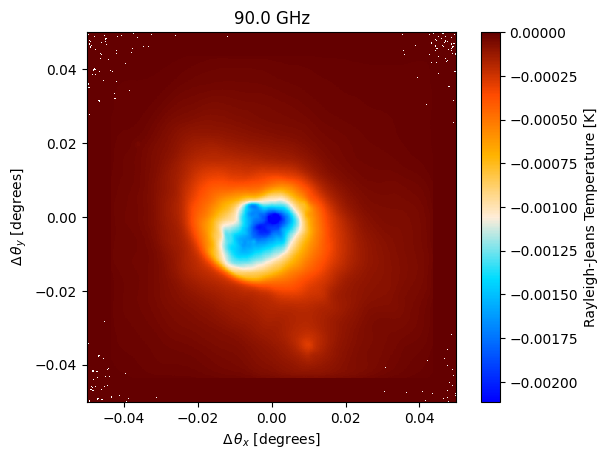

In [5]:
from maria.map.mappers import BinMapper

mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

output_truthmap.plot()

mapdata_truth = np.float64((output_truthmap.data[0])*-1e4)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

# Next, initialise nifty prior model

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

2024-07-25 15:58:59.164 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-07-25 15:58:59.166 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-07-25 15:58:59.227240: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [7]:
# dims = (128, 128)
dims = (1000, 1000)
# dims = (500, 500)

# Map model

# correlated field zero mode GP offset and stddev
cf_zm_map = dict(offset_mean=1.3, offset_std=(1e-1, 1e-1))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1.0e0, 1e-1), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-1.5e0, 1e0), # power-spectrum slope in log-log space in frequency domain (Fourier space)
    flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [40]:
# jax compatible rewrite if beams.separably_filter
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    # u, s, v = np.linalg.svd(F)
    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # TODO: jax convolution works slightly different than in scipy. Fix here!
        # filtered_image += s[m] * jax.scipy.signal.convolve(
        #     jax.scipy.signal.convolve(data, u[:, m], ), v[m],
        # )
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        # step1 = jax.scipy.signal.convolve(data, u_kernel.T, mode='same')
        # print("step1 shape", step1.shape)
        # step2 = jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')
        # print("step2 shape", step2.shape)
        # print("s[m] shape", s[m].shape)
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

        # if np.abs(F - effective_filter).mean() < tol:
        # if jax.numpy.abs(F - effective_filter).mean() < tol:
        #     break

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [41]:
import numpy as np
import scipy.ndimage

# Create an input array
input_array = np.array([1, 2, 3, 4, 5])

# Define a filter (kernel)
# kernel = np.array([1, 0, -1])
kernel = np.array([1, 0, 10])
# kernel = np.array([-0.27707011, -0.92003495, -0.27707011])

# Perform the convolution
result = scipy.ndimage.convolve1d(input_array, kernel, mode='reflect')

print("Input array:", input_array)
print("Kernel:", kernel)
print("Scipy Convolved array:", result)


Input array: [1 2 3 4 5]
Kernel: [ 1  0 10]
Scipy Convolved array: [12 13 24 35 45]


In [42]:
# a = np.array([[1,2, 3, 4, 5],[6, 7, 8, 9, 10]])
b = np.array([-0.27707011, -0.92003495, -0.27707011])
a = np.array([[1.,2. ,3.],[4., 5., 6.]])
# b = np.array([100, 10, 1])

print(a.shape)
print(b.shape)

print(a)

print("scipy:")
print("axis0:")
print(sp.ndimage.convolve1d(a, b, axis=0))
sp.ndimage.convolve1d(sp.ndimage.convolve1d(a, b, axis=0), b, axis=1)

(2, 3)
(3,)
[[1. 2. 3.]
 [4. 5. 6.]]
scipy:
axis0:
[[-2.3053855  -3.77956067 -5.25373584]
 [-5.06549035 -6.53966552 -8.01384069]]


array([[ 3.80699194,  5.57173449,  7.33647705],
       [ 7.87586997,  9.64061253, 11.40535509]])

In [43]:
a = np.array([[1.,2. ,3.],[4., 5., 6.]])

a = np.column_stack([a[:,0], a, a[:, -1]]) # axis=1
a = np.vstack([a[0], a, a[-1]]) # axis=0

# a = np.vstack([a[:, 0], a, a[:, -1]])

print(a.shape)
a

(4, 5)


array([[1., 1., 2., 3., 3.],
       [1., 1., 2., 3., 3.],
       [4., 4., 5., 6., 6.],
       [4., 4., 5., 6., 6.]])

In [44]:
# a = np.array([[1,2, 3, 4, 5],[6, 7, 8, 9, 10]])
b = np.array([-0.27707011, -0.92003495, -0.27707011])
# a = np.array([[1,2 ,3],[4, 5, 6]])
# b = np.array([100, 10, 1])


# 1D convolution
# print("1D:")
# print(np.convolve(a[:, 0], b, mode='same'))

# ND convolution
print("ND:")
b_cols = np.broadcast_to(b, (1, 3))
print(b_cols)

# scipy.signal.convolve(a, b_cols.T, mode='same')
scipy.signal.convolve(scipy.signal.convolve(a, b_cols.T, mode='same'), b_cols, mode='same')[1:-1, 1:-1]

ND:
[[-0.27707011 -0.92003495 -0.27707011]]


array([[ 3.80699194,  5.57173449,  7.33647705],
       [ 7.87586997,  9.64061253, 11.40535509]])

In [107]:
from tqdm import tqdm
from maria.constants import k_B
from maria.instrument import beams
import warnings

def sample_maps(sim_truthmap, dx, dy, instrument, resolution, x_side, y_side):
    # dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)

    data = {}
    # sim_truthmap.data["map"] = 1e-16 * np.random.standard_normal(size=dx.shape)
    data["map"] = jax.numpy.asarray(1e-16 * np.random.standard_normal(size=dx.shape))

    # pbar = tqdm(sim_truthmap.instrument.bands, disable=not sim_truthmap.verbose)
    pbar = tqdm(instrument.bands)

    for band in pbar:
        pbar.set_description(f"Sampling map ({band.name})")

        # band_mask = sim_truthmap.instrument.dets.band_name == band.name
        band_mask = instrument.dets.band_name == band.name

        nu = np.linspace(band.nu_min, band.nu_max, 64)

        # TRJ = sp.interpolate.interp1d(
        #     # sim_truthmap.map.frequency,
        #     np.array([100.]), # may need to use sth else here later!
        #     # sim_truthmap.map.data,
        #     sim_truthmap,
        #     axis=0,
        #     kind="nearest",
        #     bounds_error=False,
        #     fill_value="extrapolate",
        # )(nu)
        
        # TODO: Does this change anything when using different nu bands?
        # TRJ = jax.numpy.broadcast_to(sim_truthmap, (64, sim_truthmap.shape[1], sim_truthmap.shape[2]))
        TRJ = jax.numpy.broadcast_to(sim_truthmap, (64, 1000, 1000))

        power_map = (
            1e12
            * k_B
            # * np.trapz(band.passband(nu)[:, None, None] * TRJ, axis=0, x=1e9 * nu)
            * jax.numpy.trapezoid(band.passband(nu)[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = jax.numpy.asarray( beams.construct_beam_filter(
            # fwhm=nu_fwhm, res=sim_truthmap.map.resolution
            fwhm=nu_fwhm, res=resolution
        ) )
        
        filtered_power_map = separably_filter(power_map, nu_map_filter)

        # map_power = sp.interpolate.RegularGridInterpolator(
        # print("INPUTS map_power:")
        # print("x_side:", x_side)
        # print("y_side:", y_side)
        # print("filtered_power_map:", filtered_power_map)
        
        # print("dx[band_mask]", dx[band_mask])
        # print("dy[band_mask]", dy[band_mask])
            
        # np:
        print("x_side range:", jax.numpy.array(x_side).min(), jax.numpy.array(x_side).max())
        print("y_side range:", jax.numpy.array(y_side).min(), jax.numpy.array(y_side).max())
        print("filtered_power_map range:", 1e7*jax.numpy.array(filtered_power_map).min(), 1e7*jax.numpy.array(filtered_power_map).max())
        
        print("dx[band_mask]:", jax.numpy.array(dx[band_mask][0,0]))
        
        print(x_side.shape)
        print(y_side.shape)
        print(jax.numpy.array((x_side, y_side)).shape)
        
        print(x_side[0], y_side[0])
        print(jax.numpy.array((x_side, y_side)).T[0])
        
        print(filtered_power_map.shape)
        
        map_power_numpy = sp.interpolate.RegularGridInterpolator(
            (np.array(x_side), np.array(y_side)),
            np.array(filtered_power_map),
            bounds_error=False,
            fill_value=0,
            method="linear",
        )
        # )((dx[band_mask][0], dy[band_mask][0]))
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array(x_side), jax.numpy.array(y_side)), # length N=2 sequence of arrays with grid coords
            jax.numpy.array(filtered_power_map)*1e7, # N=2-dimensional array specifying grid values (1000, 1000) okay?
            bounds_error=False,
            fill_value=0,
            method="linear",
        )
        # )((jax.numpy.array(dx[band_mask][0]), jax.numpy.array(dy[band_mask][0])))

        print("RESULT map_power numpy", map_power_numpy((0., 0.)))
        print("RESULT map_power jax", map_power((0., 0.)))

        jax.debug.print("WARNING! No power from map!!" if (map_power == 0).all() else "Got power from map")

        # sim_truthmap.data["map"][band_mask] += map_power
        data["map"].at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data["map"]

In [108]:
sample_maps(sim_truthmap.map.data, dx, dy, instrument, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

Sampling map (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

x_side range: -0.0007596795151388355 0.0007596795151388353
y_side range: -0.0007596795151388355 0.0007596795151388353
filtered_power_map range: -6070.793433268177 -5.84407848207271
dx[band_mask]: -0.00019628652
(1000,)
(1000,)
(2, 1000)
0.0007596795151388353 0.0007596795151388353
[0.00075968 0.00075968]
(1000, 1000)
RESULT map_power numpy -0.0005301066234633575
RESULT map_power jax 0.0


AttributeError: 'bool' object has no attribute 'all'

In [15]:
# Define simple signal model with added map sampling
class Signal(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init)

    def __call__(self, x):
        return sample_maps(self.gp_map(x), dx, dy, instrument, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
    
signal_response = Signal(gp_map)

# Define noise covariance
noise_cov_inv = lambda x: 1e-1**-2 * x # 10% noise

print("mean:", mapdata_truth.mean())

# Combine in likelihood
lh = jft.Gaussian(mapdata_truth, noise_cov_inv).amend(signal_response)

Sampling map (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]


TEST
step1 shape (1002, 1002)
step2 shape (1002, 1002)
s[m] shape ()
step1 shape (1002, 1002)
step2 shape (1002, 1002)
s[m] shape ()
step1 shape (1002, 1002)
step2 shape (1002, 1002)
s[m] shape ()
INPUTS map_power:
dx[band_mask] [[-1.9628652e-04 -1.9276464e-04 -1.8971233e-04 ...  4.7382721e-04
   4.7687953e-04  4.7993180e-04]
 [-2.7118466e-04 -2.6813237e-04 -2.6484532e-04 ...  3.9798603e-04
   4.0103839e-04  4.0409074e-04]
 [-2.4559547e-04 -2.4230835e-04 -2.3878644e-04 ...  4.2851540e-04
   4.3156778e-04  4.3462013e-04]
 ...
 [-4.0474121e-04 -4.0145448e-04 -3.9816773e-04 ...  2.2961208e-04
   2.3266416e-04  2.3571622e-04]
 [-5.1400432e-04 -5.1071699e-04 -5.0742965e-04 ...  1.8691758e-04
   1.8973541e-04  1.9302288e-04]
 [-7.4873149e-04 -7.4544450e-04 -7.4215751e-04 ... -8.7813336e-05
  -8.4760992e-05 -8.1708640e-05]]
dy[band_mask] [[ 9.6262323e-05  9.6013559e-05  9.5849646e-05 ... -9.4737858e-05
  -9.3942297e-05 -9.2972456e-05]
 [ 1.0961054e-04  1.0944663e-04  1.0916806e-04 ... -8.6159

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

# MAP fit

In [ ]:
n_it = 1
# delta = 1e-4 # default
delta = 1e-8 # here
n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
Sampling map (m2/f093): 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


TEST
step1 shape (1002, 1002)
step2 shape (1002, 1002)
s[m] shape ()
step1 shape (1002, 1002)
step2 shape (1002, 1002)
s[m] shape ()
step1 shape (1002, 1002)
step2 shape (1002, 1002)
s[m] shape ()
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


TypeError: sub got incompatible shapes for broadcasting: (500, 500), (217, 30000).

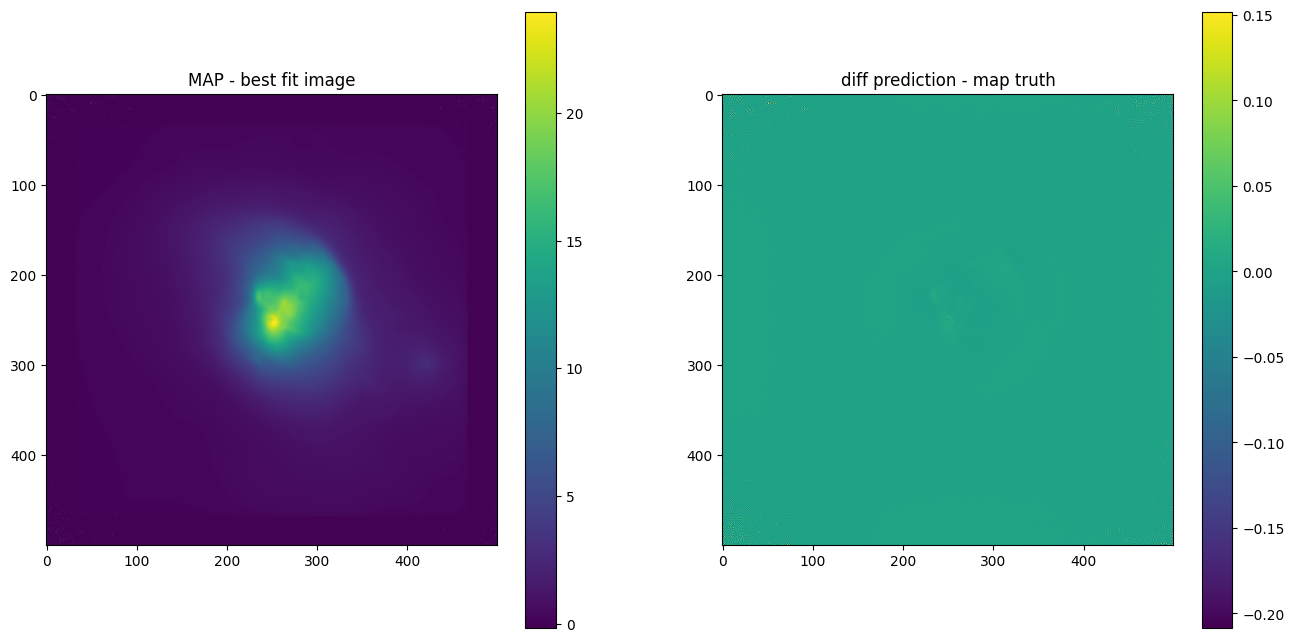

In [ ]:
# plot maximum of posterior (mode)
sig_map = signal_response(samples.pos)
# sig_map = gp(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( (sig_map - mapdata_truth) )
axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()